- Fuente original: https://www.kaggle.com/mateuszbuda/lgg-mri-segmentation


# IMPORTAR LIBRERÍAS Y DATASETS

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import zipfile
import cv2
from skimage import io
import tensorflow as tf
from tensorflow.python.keras import Sequential
from tensorflow.keras import layers, optimizers
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.initializers import glorot_uniform
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint, LearningRateScheduler
from IPython.display import display
from tensorflow.keras import backend as K
from sklearn.preprocessing import StandardScaler, normalize
import os
import glob
import random
from google.colab import files
%matplotlib inline

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Se dtermina la carpeta de trabajo para cargar los ficheros
%cd /content/drive/MyDrive/01_Oriol/01_Machine Learning/07_Masterclass-IA-Moderna/IA_Healthcare/Datasets


/content/drive/MyDrive/01_Oriol/01_Machine Learning/07_Masterclass-IA-Moderna/IA_Healthcare/Datasets


In [ ]:
# Datos que contienen la ruta al dataset y su máscara correspondiente
brain_df = pd.read_csv('data_mask.csv')

In [ ]:
brain_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3929 entries, 0 to 3928
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   patient_id  3929 non-null   object
 1   image_path  3929 non-null   object
 2   mask_path   3929 non-null   object
 3   mask        3929 non-null   int64 
dtypes: int64(1), object(3)
memory usage: 122.9+ KB


In [ ]:
brain_df.head(50)

patient_id  ... mask
0   TCGA_CS_5395_19981004  ...    0
1   TCGA_CS_5395_19981004  ...    0
2   TCGA_CS_5395_19981004  ...    0
3   TCGA_CS_5395_19981004  ...    0
4   TCGA_CS_5395_19981004  ...    0
5   TCGA_CS_5395_19981004  ...    0
6   TCGA_CS_5395_19981004  ...    0
7   TCGA_CS_5395_19981004  ...    0
8   TCGA_CS_5395_19981004  ...    0
9   TCGA_CS_5395_19981004  ...    0
10  TCGA_CS_5395_19981004  ...    0
11  TCGA_CS_5395_19981004  ...    0
12  TCGA_CS_5395_19981004  ...    0
13  TCGA_CS_5395_19981004  ...    0
14  TCGA_CS_5395_19981004  ...    0
15  TCGA_CS_5395_19981004  ...    0
16  TCGA_CS_5395_19981004  ...    0
17  TCGA_CS_5395_19981004  ...    0
18  TCGA_CS_5395_19981004  ...    0
19  TCGA_CS_5395_19981004  ...    0
20  TCGA_CS_4944_20010208  ...    0
21  TCGA_CS_4944_20010208  ...    0
22  TCGA_CS_4944_20010208  ...    0
23  TCGA_CS_4944_20010208  ...    0
24  TCGA_CS_4944_20010208  ...    0
25  TCGA_CS_4944_20010208  ...    0
26  TCGA_CS_4944_20010208  ...    0
27  TCGA_CS_4944_20010208  ...    0
28  TCGA_CS_4944_20010208  ...    0
29  TCGA_CS_4944_20010208  ...    0
30  TCGA_CS_4944_20010208  ...    0
31  TCGA_CS_4944_20010208  ...    0
32  TCGA_CS_4944_20010208  ...    0
33  TCGA_CS_4944_20010208  ...    0
34  TCGA_CS_4944_20010208  ...    0
35  TCGA_CS_4944_20010208  ...    0
36  TCGA_CS_4944_20010208  ...    0
37  TCGA_CS_4944_20010208  ...    0
38  TCGA_CS_4944_20010208  ...    0
39  TCGA_CS_4944_20010208  ...    0
40  TCGA_CS_4941_19960909  ...    0
41  TCGA_CS_4941_19960909  ...    0
42  TCGA_CS_4941_19960909  ...    0
43  TCGA_CS_4941_19960909  ...    0
44  TCGA_CS_4941_19960909  ...    0
45  TCGA_CS_4941_19960909  ...    0
46  TCGA_CS_4941_19960909  ...    0
47  TCGA_CS_4941_19960909  ...    0
48  TCGA_CS_4941_19960909  ...    0
49  TCGA_CS_4941_19960909  ...    0

[50 rows x 4 columns]

In [ ]:
brain_df.mask_path[1] # Ruta a la máscara de la MRI

'TCGA_CS_4944_20010208/TCGA_CS_4944_20010208_1_mask.tif'

In [ ]:
brain_df.image_path[1] # Ruta a la imagen de segmentación

'TCGA_CS_4944_20010208/TCGA_CS_4944_20010208_1.tif'

In [ ]:
# Obtener el número de imágenes con máscara
brain_df['mask'].value_counts()

0    2556
1    1373
Name: mask, dtype: int64

# VISUALIZACIÓN DE DATOS

In [ ]:
brain_df

patient_id  ... mask
0     TCGA_CS_5395_19981004  ...    0
1     TCGA_CS_5395_19981004  ...    0
2     TCGA_CS_5395_19981004  ...    0
3     TCGA_CS_5395_19981004  ...    0
4     TCGA_CS_5395_19981004  ...    0
...                     ...  ...  ...
3924  TCGA_DU_6401_19831001  ...    0
3925  TCGA_DU_6401_19831001  ...    0
3926  TCGA_DU_6401_19831001  ...    0
3927  TCGA_DU_6401_19831001  ...    0
3928  TCGA_DU_6401_19831001  ...    0

[3929 rows x 4 columns]

In [ ]:
brain_df['mask'].value_counts().index

Int64Index([0, 1], dtype='int64')

In [ ]:
# Usamos plotly para hacer un diagrama de barras interactivo
import plotly.graph_objects as go

fig = go.Figure([go.Bar(x = brain_df['mask'].value_counts().index, y = brain_df['mask'].value_counts())])
fig.update_traces(marker_color = 'rgb(0,200,0)', marker_line_color = 'rgb(0,255,0)',
                  marker_line_width = 7, opacity = 0.6)
fig.show()

In [ ]:
brain_df.mask_path

0       TCGA_CS_5395_19981004/TCGA_CS_5395_19981004_1_...
1       TCGA_CS_4944_20010208/TCGA_CS_4944_20010208_1_...
2       TCGA_CS_4941_19960909/TCGA_CS_4941_19960909_1_...
3       TCGA_CS_4943_20000902/TCGA_CS_4943_20000902_1_...
4       TCGA_CS_5396_20010302/TCGA_CS_5396_20010302_1_...
                              ...                        
3924    TCGA_HT_A61B_19991127/TCGA_HT_A61B_19991127_86...
3925    TCGA_HT_A61A_20000127/TCGA_HT_A61A_20000127_87...
3926    TCGA_HT_A61B_19991127/TCGA_HT_A61B_19991127_87...
3927    TCGA_HT_A61A_20000127/TCGA_HT_A61A_20000127_88...
3928    TCGA_HT_A61B_19991127/TCGA_HT_A61B_19991127_88...
Name: mask_path, Length: 3929, dtype: object

In [ ]:
brain_df.image_path

0       TCGA_CS_5395_19981004/TCGA_CS_5395_19981004_1.tif
1       TCGA_CS_4944_20010208/TCGA_CS_4944_20010208_1.tif
2       TCGA_CS_4941_19960909/TCGA_CS_4941_19960909_1.tif
3       TCGA_CS_4943_20000902/TCGA_CS_4943_20000902_1.tif
4       TCGA_CS_5396_20010302/TCGA_CS_5396_20010302_1.tif
                              ...                        
3924    TCGA_HT_A61B_19991127/TCGA_HT_A61B_19991127_86...
3925    TCGA_HT_A61A_20000127/TCGA_HT_A61A_20000127_87...
3926    TCGA_HT_A61B_19991127/TCGA_HT_A61B_19991127_87...
3927    TCGA_HT_A61A_20000127/TCGA_HT_A61A_20000127_88...
3928    TCGA_HT_A61B_19991127/TCGA_HT_A61B_19991127_88...
Name: image_path, Length: 3929, dtype: object

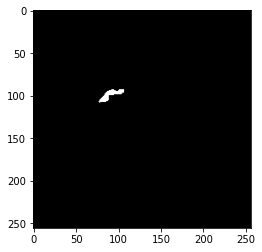

In [ ]:
plt.imshow(cv2.imread(brain_df.mask_path[623]))

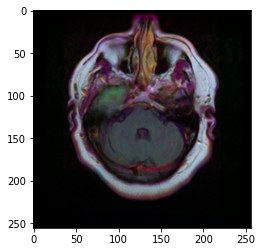

In [ ]:
plt.imshow(cv2.imread(brain_df.image_path[623]))

In [ ]:
cv2.imread(brain_df.mask_path[623]).max()

255

In [ ]:
cv2.imread(brain_df.mask_path[623]).min()

0

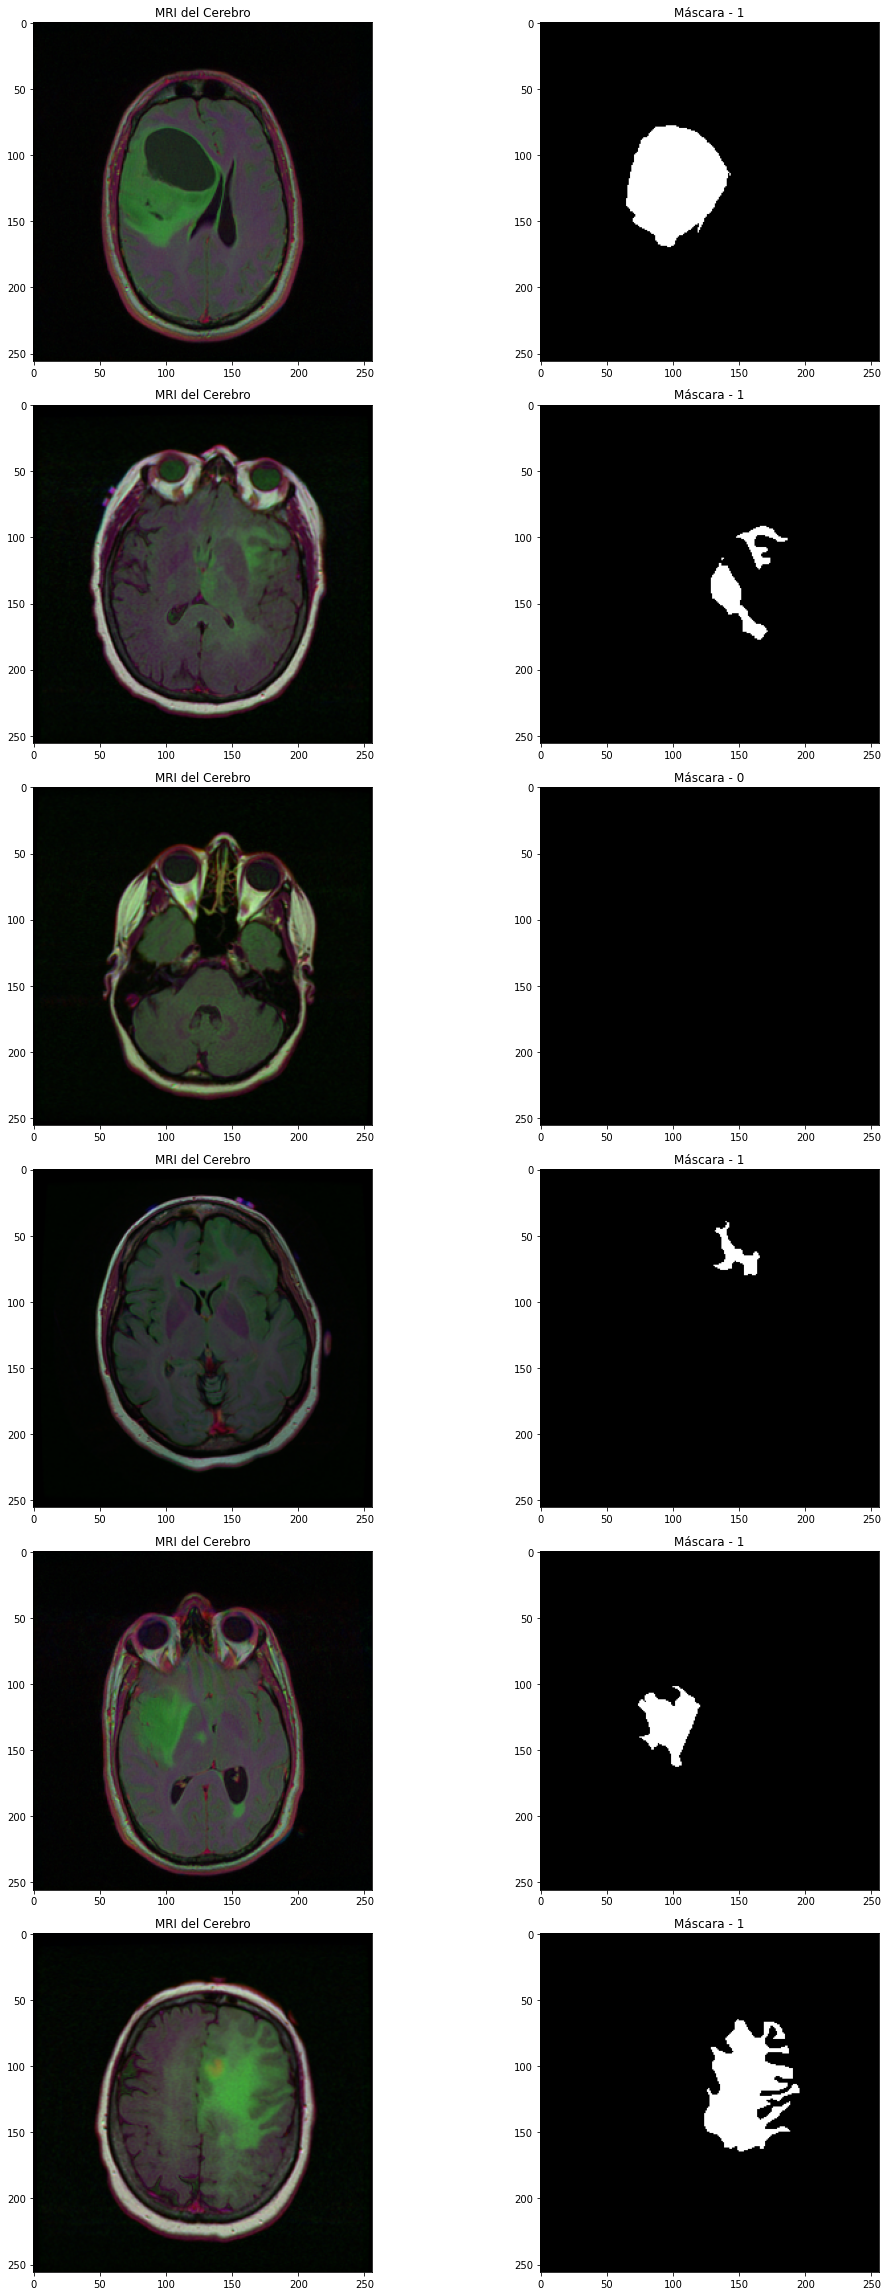

In [ ]:
# Visualización básica. Visualización de las imágenes (MRI y Máscaras) en el dataset de forma separada
import random
fig, axs = plt.subplots(6,2, figsize=(16,32))
count = 0
for x in range(6):
  i = random.randint(0, len(brain_df)) # Seleccionamos un índice aleatorio
  axs[count][0].title.set_text("MRI del Cerebro") # Configuramos el título
  axs[count][0].imshow(cv2.imread(brain_df.image_path[i])) # Mostramos la MRI 
  axs[count][1].title.set_text("Máscara - " + str(brain_df['mask'][i])) # Colocámos el título en la máscara (0 o 1)
  axs[count][1].imshow(cv2.imread(brain_df.mask_path[i])) # Mostramos la máscara correspondiente 
  count += 1

fig.tight_layout()

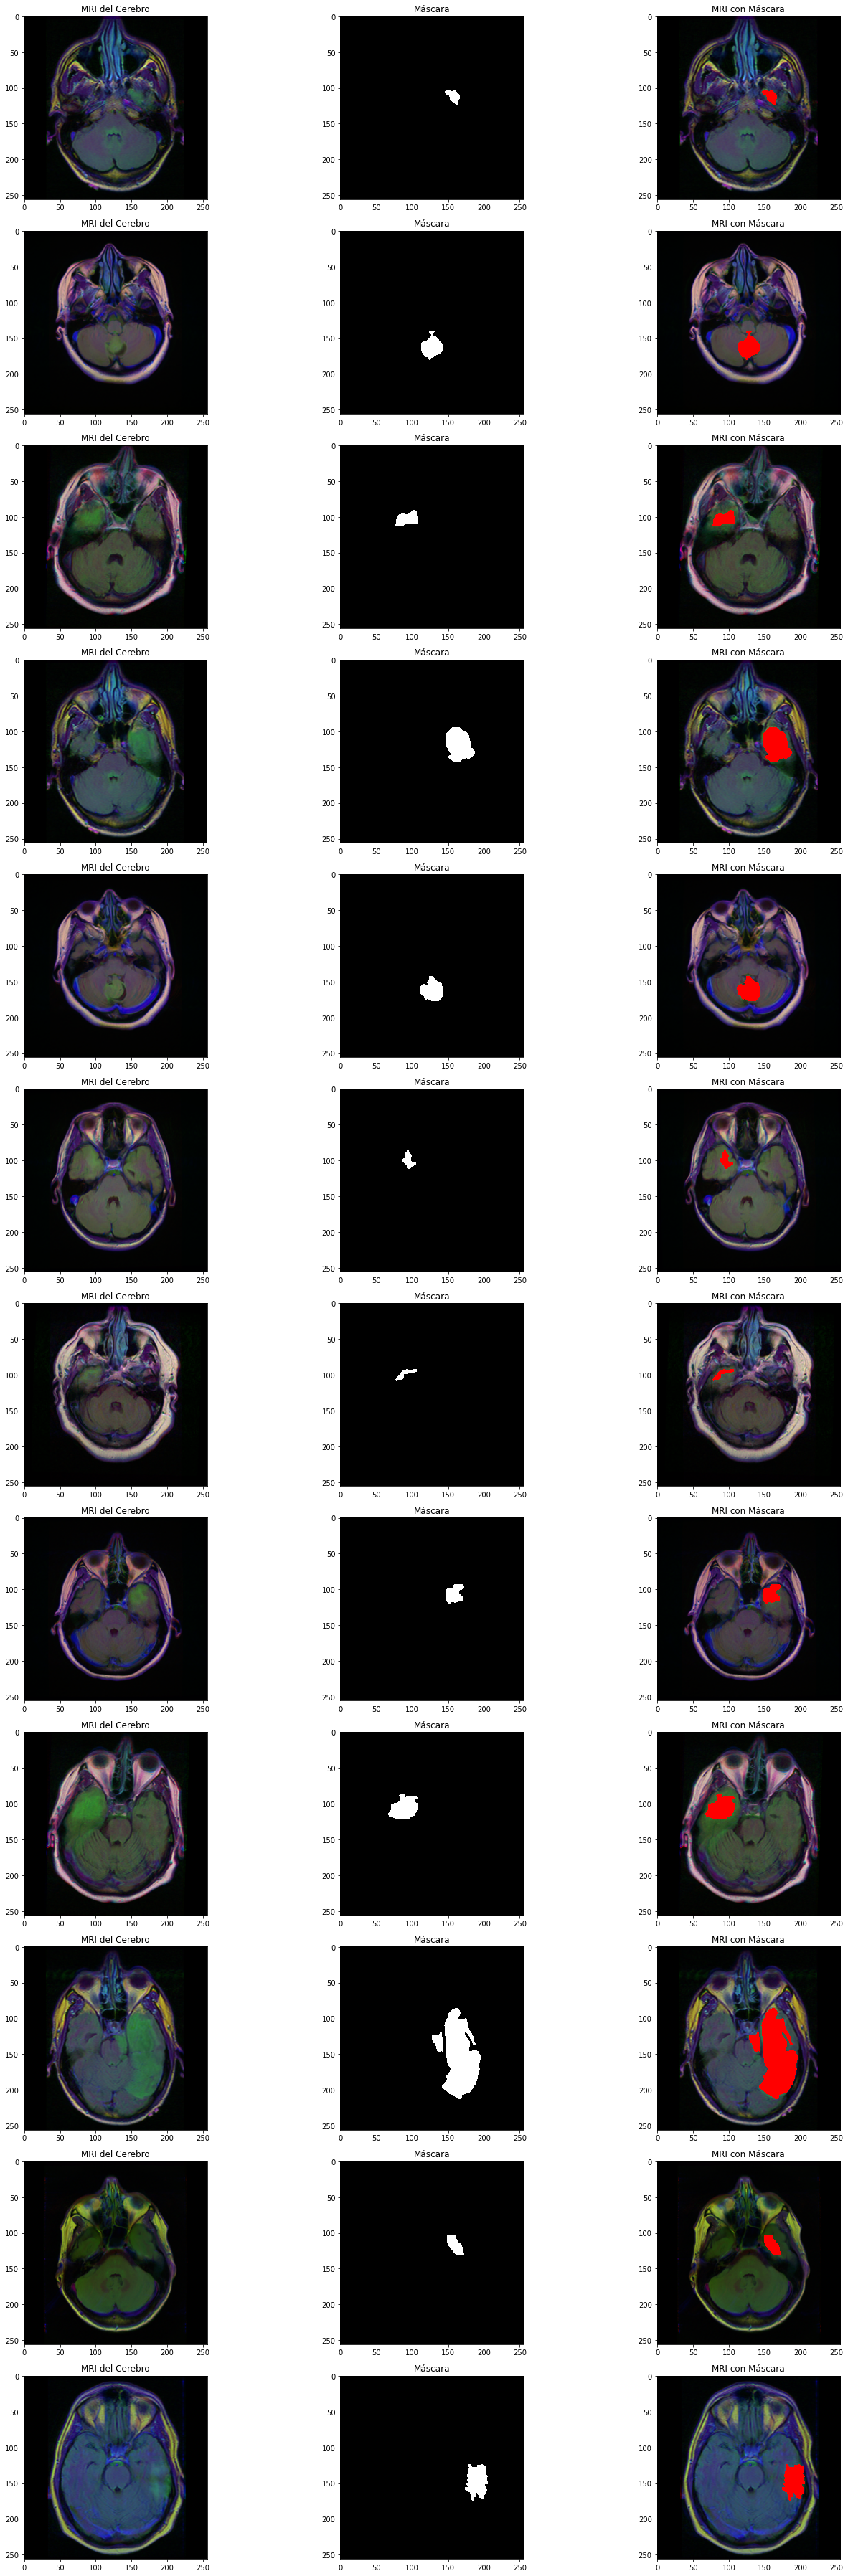

In [ ]:
count = 0
fig, axs = plt.subplots(12, 3, figsize = (20, 50))
for i in range(len(brain_df)):
  if brain_df['mask'][i] ==1 and count <12:
    img = io.imread(brain_df.image_path[i])
    axs[count][0].title.set_text('MRI del Cerebro')
    axs[count][0].imshow(img)

    mask = io.imread(brain_df.mask_path[i])
    axs[count][1].title.set_text('Máscara')
    axs[count][1].imshow(mask, cmap = 'gray')

    
    img[mask == 255] = (255, 0, 0)
    axs[count][2].title.set_text('MRI con Máscara')
    axs[count][2].imshow(img)
    count+=1

fig.tight_layout()


# ENTRENAR UN MODELO CLASIFICADOR PARA DETECTAR SI EXISTE TUMOR O NO

In [ ]:
# Se elimina la columna de identificador del paciente
brain_df_train = brain_df.drop(columns = ['patient_id'])
brain_df_train.shape

(3929, 3)

In [ ]:
# Convertir los datos en la columna de máscara a formato de string, para usar el modo categórico en flow_from_dataframe

brain_df_train['mask'] = brain_df_train['mask'].apply(lambda x: str(x))

In [ ]:
brain_df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3929 entries, 0 to 3928
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   image_path  3929 non-null   object
 1   mask_path   3929 non-null   object
 2   mask        3929 non-null   object
dtypes: object(3)
memory usage: 92.2+ KB


In [ ]:
# Dividir los datos en entrenamiento y testing

from sklearn.model_selection import train_test_split

train, test = train_test_split(brain_df_train, test_size = 0.15)

In [ ]:
# Creamos el generador de imágenes
from keras_preprocessing.image import ImageDataGenerator

# Creamos un generador de datos que escale los datos de 0 a 1 y haga una división de validación de 0,15
datagen = ImageDataGenerator(rescale=1./255., validation_split = 0.15)


In [ ]:
train_generator=datagen.flow_from_dataframe(
dataframe=train,
directory= './',
x_col='image_path',
y_col='mask',
subset="training",
batch_size=16,
shuffle=True,
class_mode="categorical",
target_size=(256,256))


valid_generator=datagen.flow_from_dataframe(
dataframe=train,
directory= './',
x_col='image_path',
y_col='mask',
subset="validation",
batch_size=16,
shuffle=True,
class_mode="categorical",
target_size=(256,256))

# Creamos un generador de datos para imágenes de prueba
test_datagen=ImageDataGenerator(rescale=1./255.)

test_generator=test_datagen.flow_from_dataframe(
dataframe=test,
directory= './',
x_col='image_path',
y_col='mask',
batch_size=16,
shuffle=False,
class_mode='categorical',
target_size=(256,256))



Found 2839 validated image filenames belonging to 2 classes.
Found 500 validated image filenames belonging to 2 classes.
Found 590 validated image filenames belonging to 2 classes.


In [ ]:
# Obtenemos el modelo base de ResNet50 
basemodel = ResNet50(weights = 'imagenet', include_top = False, input_tensor = Input(shape=(256, 256, 3)))

94773248/94765736 [==============================] - 0s 0us/step


In [ ]:
basemodel.summary()

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 262, 262, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 128, 128, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 128, 128, 64) 256         conv1_conv[0][0]                 
___________________________________________________________________________________________

In [ ]:
# Congelamos los pesos del modelo

for layer in basemodel.layers:
  layers.trainable = False

In [ ]:
# Agregamos una cabecera de clasificación al modelo base

headmodel = basemodel.output
headmodel = AveragePooling2D(pool_size = (4,4))(headmodel)
headmodel = Flatten(name= 'flatten')(headmodel)
headmodel = Dense(256, activation = "relu")(headmodel)
headmodel = Dropout(0.3)(headmodel)
headmodel = Dense(256, activation = "relu")(headmodel)
headmodel = Dropout(0.3)(headmodel)
headmodel = Dense(256, activation = "relu")(headmodel)
headmodel = Dropout(0.3)(headmodel)
headmodel = Dense(2, activation = 'softmax')(headmodel)

model = Model(inputs = basemodel.input, outputs = headmodel)

In [ ]:
model.summary()

Model: "functional_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 262, 262, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 128, 128, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 128, 128, 64) 256         conv1_conv[0][0]                 
_______________________________________________________________________________________

In [ ]:
# Compilamos el modelo

model.compile(loss = 'categorical_crossentropy', optimizer='adam', metrics= ["accuracy"])

In [ ]:
# Utilizamos la parada temprana para salir del entrenamiento si la pérdida en la validación no disminuye incluso después de ciertas épocas (paciencia)
earlystopping = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=20)

# Guardamos el mejor modelo con la menor pérdida de validación
checkpointer = ModelCheckpoint(filepath="classifier-resnet-weights.hdf5", verbose=1, save_best_only=True)

In [ ]:
history = model.fit(train_generator, steps_per_epoch= train_generator.n // 16, epochs = 1, validation_data= valid_generator, validation_steps= valid_generator.n // 16, callbacks=[checkpointer, earlystopping])

177/177 [==============================] - ETA: 0s - loss: 0.6623 - accuracy: 0.7109
Epoch 00001: val_loss improved from inf to 0.66605, saving model to classifier-resnet-weights.hdf5
177/177 [==============================] - 939s 5s/step - loss: 0.6623 - accuracy: 0.7109 - val_loss: 0.6661 - val_accuracy: 0.6431


In [ ]:
# Guardamos la arquitectura del modelo en un archivo json para uso futuro

model_json = model.to_json()
with open("classifier-resnet-model.json","w") as json_file:
  json_file.write(model_json)

# EVALUA EL RENDIMIENTO DEL MODELO ENTRENADO

In [ ]:
# Cargamos el modelo preentrenado mejorado
with open('resnet-50-MRI.json', 'r') as json_file:
    json_savedModel= json_file.read()
# Cargar el modelo  
model = tf.keras.models.model_from_json(json_savedModel)
model.load_weights('weights.hdf5')
model.compile(loss = 'categorical_crossentropy', optimizer='adam', metrics= ["accuracy"])

In [ ]:
# Hacemos la predicción

test_predict = model.predict(test_generator, steps = test_generator.n // 16, verbose =1)

36/36 [==============================] - 137s 4s/step


In [ ]:
test_predict.shape

(576, 2)

In [ ]:
test_predict

array([[1.1592417e-15, 1.0000000e+00],
       [8.2643256e-03, 9.9173564e-01],
       [4.2386501e-14, 1.0000000e+00],
       ...,
       [2.6559606e-08, 1.0000000e+00],
       [7.9192305e-11, 1.0000000e+00],
       [2.1022929e-07, 9.9999976e-01]], dtype=float32)

In [ ]:
# Obtenemos la clase predicha a partir del modelo
predict = []

for i in test_predict:
  predict.append(str(np.argmax(i)))

predict = np.asarray(predict)

In [ ]:
predict

array(['1', '1', '1', '0', '0', '0', '0', '1', '1', '0', '1', '0', '1',
       '0', '1', '0', '0', '0', '0', '1', '0', '0', '0', '1', '0', '0',
       '1', '0', '0', '1', '0', '0', '1', '0', '0', '1', '0', '0', '0',
       '0', '0', '1', '1', '0', '0', '0', '1', '1', '1', '0', '1', '0',
       '0', '0', '0', '0', '0', '0', '1', '0', '0', '0', '0', '0', '0',
       '0', '0', '0', '1', '0', '1', '0', '1', '1', '0', '0', '0', '0',
       '0', '0', '0', '0', '0', '0', '0', '1', '0', '0', '0', '1', '0',
       '0', '0', '1', '1', '0', '0', '0', '1', '0', '1', '0', '0', '0',
       '0', '1', '0', '0', '0', '0', '0', '0', '0', '0', '1', '0', '1',
       '0', '0', '1', '0', '0', '0', '0', '1', '0', '0', '0', '1', '0',
       '0', '0', '0', '0', '0', '0', '1', '0', '0', '1', '0', '1', '0',
       '1', '0', '0', '0', '0', '0', '0', '0', '0', '0', '1', '0', '0',
       '1', '0', '0', '1', '0', '1', '0', '0', '1', '1', '0', '0', '0',
       '0', '1', '1', '0', '0', '0', '0', '0', '0', '1', '0', '0

In [ ]:
# Dado que se usa el generador de prueba, se limita el número de imágenes a leer (predecir), debido al tamaño del lote
original = np.asarray(test['mask'])[:len(predict)]
len(original)

576

In [ ]:
# Obtenemos la tasa de acierto del modelo
from sklearn.metrics import accuracy_score

accuracy = accuracy_score(original, predict)
accuracy

0.9826388888888888

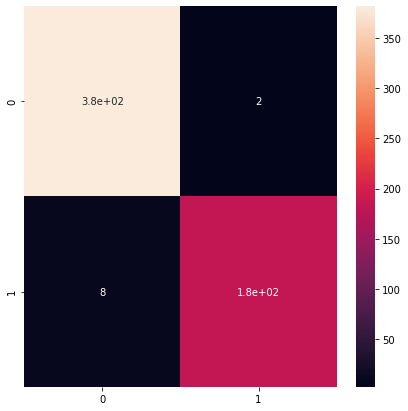

In [ ]:
# Representamos la matriz de confusión
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(original, predict)
plt.figure(figsize = (7,7))
sns.heatmap(cm, annot=True)

In [ ]:
from sklearn.metrics import classification_report

report = classification_report(original, predict, labels = [0,1])
print(report)

              precision    recall  f1-score   support

           0       0.98      0.99      0.99       384
           1       0.99      0.96      0.97       192

   micro avg       0.98      0.98      0.98       576
   macro avg       0.98      0.98      0.98       576
weighted avg       0.98      0.98      0.98       576



/usr/local/lib/python3.6/dist-packages/numpy/lib/arraysetops.py:576: FutureWarning:

elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison



# CONSTRUIR EL MODELO DE SEGMENTACIÓN PARA LOCALIZAR EL TUMOR

In [ ]:
# Obtenemos el dataframe que contiene las resonancias magnéticas que tienen máscaras asociadas.
brain_df_mask = brain_df[brain_df['mask'] == 1]
brain_df_mask.shape

(1373, 4)

In [ ]:
# Dividir los datos en datos de prueba y de test

from sklearn.model_selection import train_test_split

X_train, X_val = train_test_split(brain_df_mask, test_size=0.15)
X_test, X_val = train_test_split(X_val, test_size=0.5)

In [ ]:
# Crear una lista separada para imageId, classId para pasar al generador

train_ids = list(X_train.image_path)
train_mask = list(X_train.mask_path)

val_ids = list(X_val.image_path)
val_mask= list(X_val.mask_path)

In [ ]:
# El archivo de utilidades contiene el código para la función de pérdida personalizada y el generador de datos personalizados
from utilities import DataGenerator

# Creamos los generadores de imágenes

training_generator = DataGenerator(train_ids,train_mask)
validation_generator = DataGenerator(val_ids,val_mask)

In [ ]:
def resblock(X, f):
  

  # Hacemos la copia de la entrada
  X_copy = X

  # Ruta principal
  
  X = Conv2D(f, kernel_size = (1,1) ,strides = (1,1),kernel_initializer ='he_normal')(X)
  X = BatchNormalization()(X)
  X = Activation('relu')(X) 

  X = Conv2D(f, kernel_size = (3,3), strides =(1,1), padding = 'same', kernel_initializer ='he_normal')(X)
  X = BatchNormalization()(X)

  # Ruta corta
  
  X_copy = Conv2D(f, kernel_size = (1,1), strides =(1,1), kernel_initializer ='he_normal')(X_copy)
  X_copy = BatchNormalization()(X_copy)

    # Agregar la salida de la ruta principal y la ruta corta juntas

  X = Add()([X,X_copy])
  X = Activation('relu')(X)

  return X

In [ ]:
# Función para escalar y concatenar los valores pasados
def upsample_concat(x, skip):
  x = UpSampling2D((2,2))(x)
  merge = Concatenate()([x, skip])

  return merge

In [ ]:
input_shape = (256,256,3)

# Forma del tensor de entrada
X_input = Input(input_shape)

# Fase 1
conv1_in = Conv2D(16,3,activation= 'relu', padding = 'same', kernel_initializer ='he_normal')(X_input)
conv1_in = BatchNormalization()(conv1_in)
conv1_in = Conv2D(16,3,activation= 'relu', padding = 'same', kernel_initializer ='he_normal')(conv1_in)
conv1_in = BatchNormalization()(conv1_in)
pool_1 = MaxPool2D(pool_size = (2,2))(conv1_in)

# Fase 2
conv2_in = resblock(pool_1, 32)
pool_2 = MaxPool2D(pool_size = (2,2))(conv2_in)

# Fase 3
conv3_in = resblock(pool_2, 64)
pool_3 = MaxPool2D(pool_size = (2,2))(conv3_in)

# Fase 4
conv4_in = resblock(pool_3, 128)
pool_4 = MaxPool2D(pool_size = (2,2))(conv4_in)

# Fase 5 (Cuello de Botella)
conv5_in = resblock(pool_4, 256)

# Fase de Escalada 1
up_1 = upsample_concat(conv5_in, conv4_in)
up_1 = resblock(up_1, 128)

# Fase de Escalada 2
up_2 = upsample_concat(up_1, conv3_in)
up_2 = resblock(up_2, 64)

# Fase de Escalada 3
up_3 = upsample_concat(up_2, conv2_in)
up_3 = resblock(up_3, 32)

# Fase de Escalada 4
up_4 = upsample_concat(up_3, conv1_in)
up_4 = resblock(up_4, 16)

# Salida Final
output = Conv2D(1, (1,1), padding = "same", activation = "sigmoid")(up_4)

model_seg = Model(inputs = X_input, outputs = output )


In [ ]:
model_seg.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 256, 256, 16) 448         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 256, 256, 16) 64          conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 256, 256, 16) 2320        batch_normalization[0][0]        
______________________________________________________________________________________________

# ENTRENAR EL MODELO DE RESUNET DE SEGMENTACIÓN PARA LOCALIZAR EL TUMOR

In [ ]:
# El archivo de utilidades contiene el código para la función de pérdida personalizada y el generador de datos personalizados

from utilities import focal_tversky, tversky_loss, tversky

In [ ]:
# Compilamos el modelo
adam = tf.keras.optimizers.Adam(lr = 0.05, epsilon = 0.1)
model_seg.compile(optimizer = adam, loss = focal_tversky, metrics = [tversky])

In [ ]:
# Usamos la parada temprana para salir del entrenamiento si la pérdida de validación no disminuye incluso después de ciertas épocas (paciencia)
earlystopping = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=20)

# Guardamos el mejor modelo con menor pérdida de validación
checkpointer = ModelCheckpoint(filepath="ResUNet-weights.hdf5", verbose=1, save_best_only=True)

In [ ]:
history = model_seg.fit(training_generator , epochs = 1, validation_data = validation_generator, callbacks = [checkpointer, earlystopping])

In [ ]:
# Guardamos la arquitectura del modelo en un archivo json para uso futuro

model_json = model_seg.to_json()
with open("ResUNet-model.json","w") as json_file:
  json_file.write(model_json)

# EVALUAR EL RENDIMIENTO DEL MODELO DE RESUNET DE SEGMENTACIÓN ENTRENADA

In [ ]:
from utilities import focal_tversky, tversky_loss, tversky

with open('ResUNet-MRI.json', 'r') as json_file:
    json_savedModel= json_file.read()

# cargar la arquitectura del modelo
model_seg = tf.keras.models.model_from_json(json_savedModel)
model_seg.load_weights('weights_seg.hdf5')
adam = tf.keras.optimizers.Adam(lr = 0.05, epsilon = 0.1)
model_seg.compile(optimizer = adam, loss = focal_tversky, metrics = [tversky])

In [ ]:
# El archivo de utilidades contiene el código para la función de pérdida personalizada y el generador de datos personalizados
from utilities import prediction

# Hacemos la predicción
image_id, mask, has_mask = prediction(test, model, model_seg)

In [ ]:
# Creamos el dataframe para el resultado
df_pred = pd.DataFrame({'image_path': image_id,'predicted_mask': mask,'has_mask': has_mask})
df_pred

image_path  ... has_mask
0    TCGA_FG_A4MT_20020212/TCGA_FG_A4MT_20020212_21...  ...        1
1    TCGA_HT_7856_19950831/TCGA_HT_7856_19950831_19...  ...        1
2    TCGA_HT_8114_19981030/TCGA_HT_8114_19981030_18...  ...        1
3    TCGA_CS_5395_19981004/TCGA_CS_5395_19981004_1.tif  ...        0
4    TCGA_FG_A4MU_20030903/TCGA_FG_A4MU_20030903_33...  ...        0
..                                                 ...  ...      ...
585  TCGA_FG_6689_20020326/TCGA_FG_6689_20020326_33...  ...        1
586  TCGA_DU_5849_19950405/TCGA_DU_5849_19950405_25...  ...        1
587  TCGA_HT_7693_19950520/TCGA_HT_7693_19950520_4.tif  ...        0
588  TCGA_HT_8107_19980708/TCGA_HT_8107_19980708_7.tif  ...        0
589  TCGA_DU_6400_19830518/TCGA_DU_6400_19830518_40...  ...        0

[590 rows x 3 columns]

In [ ]:
# Fusionar el data frame que contiene los resultados previstos con los datos de prueba originales.
df_pred = test.merge(df_pred, on = 'image_path')
df_pred.head()

image_path  ... has_mask
0  TCGA_FG_A4MT_20020212/TCGA_FG_A4MT_20020212_21...  ...        1
1  TCGA_HT_7856_19950831/TCGA_HT_7856_19950831_19...  ...        1
2  TCGA_HT_8114_19981030/TCGA_HT_8114_19981030_18...  ...        1
3  TCGA_CS_5395_19981004/TCGA_CS_5395_19981004_1.tif  ...        0
4  TCGA_FG_A4MU_20030903/TCGA_FG_A4MU_20030903_33...  ...        0

[5 rows x 5 columns]

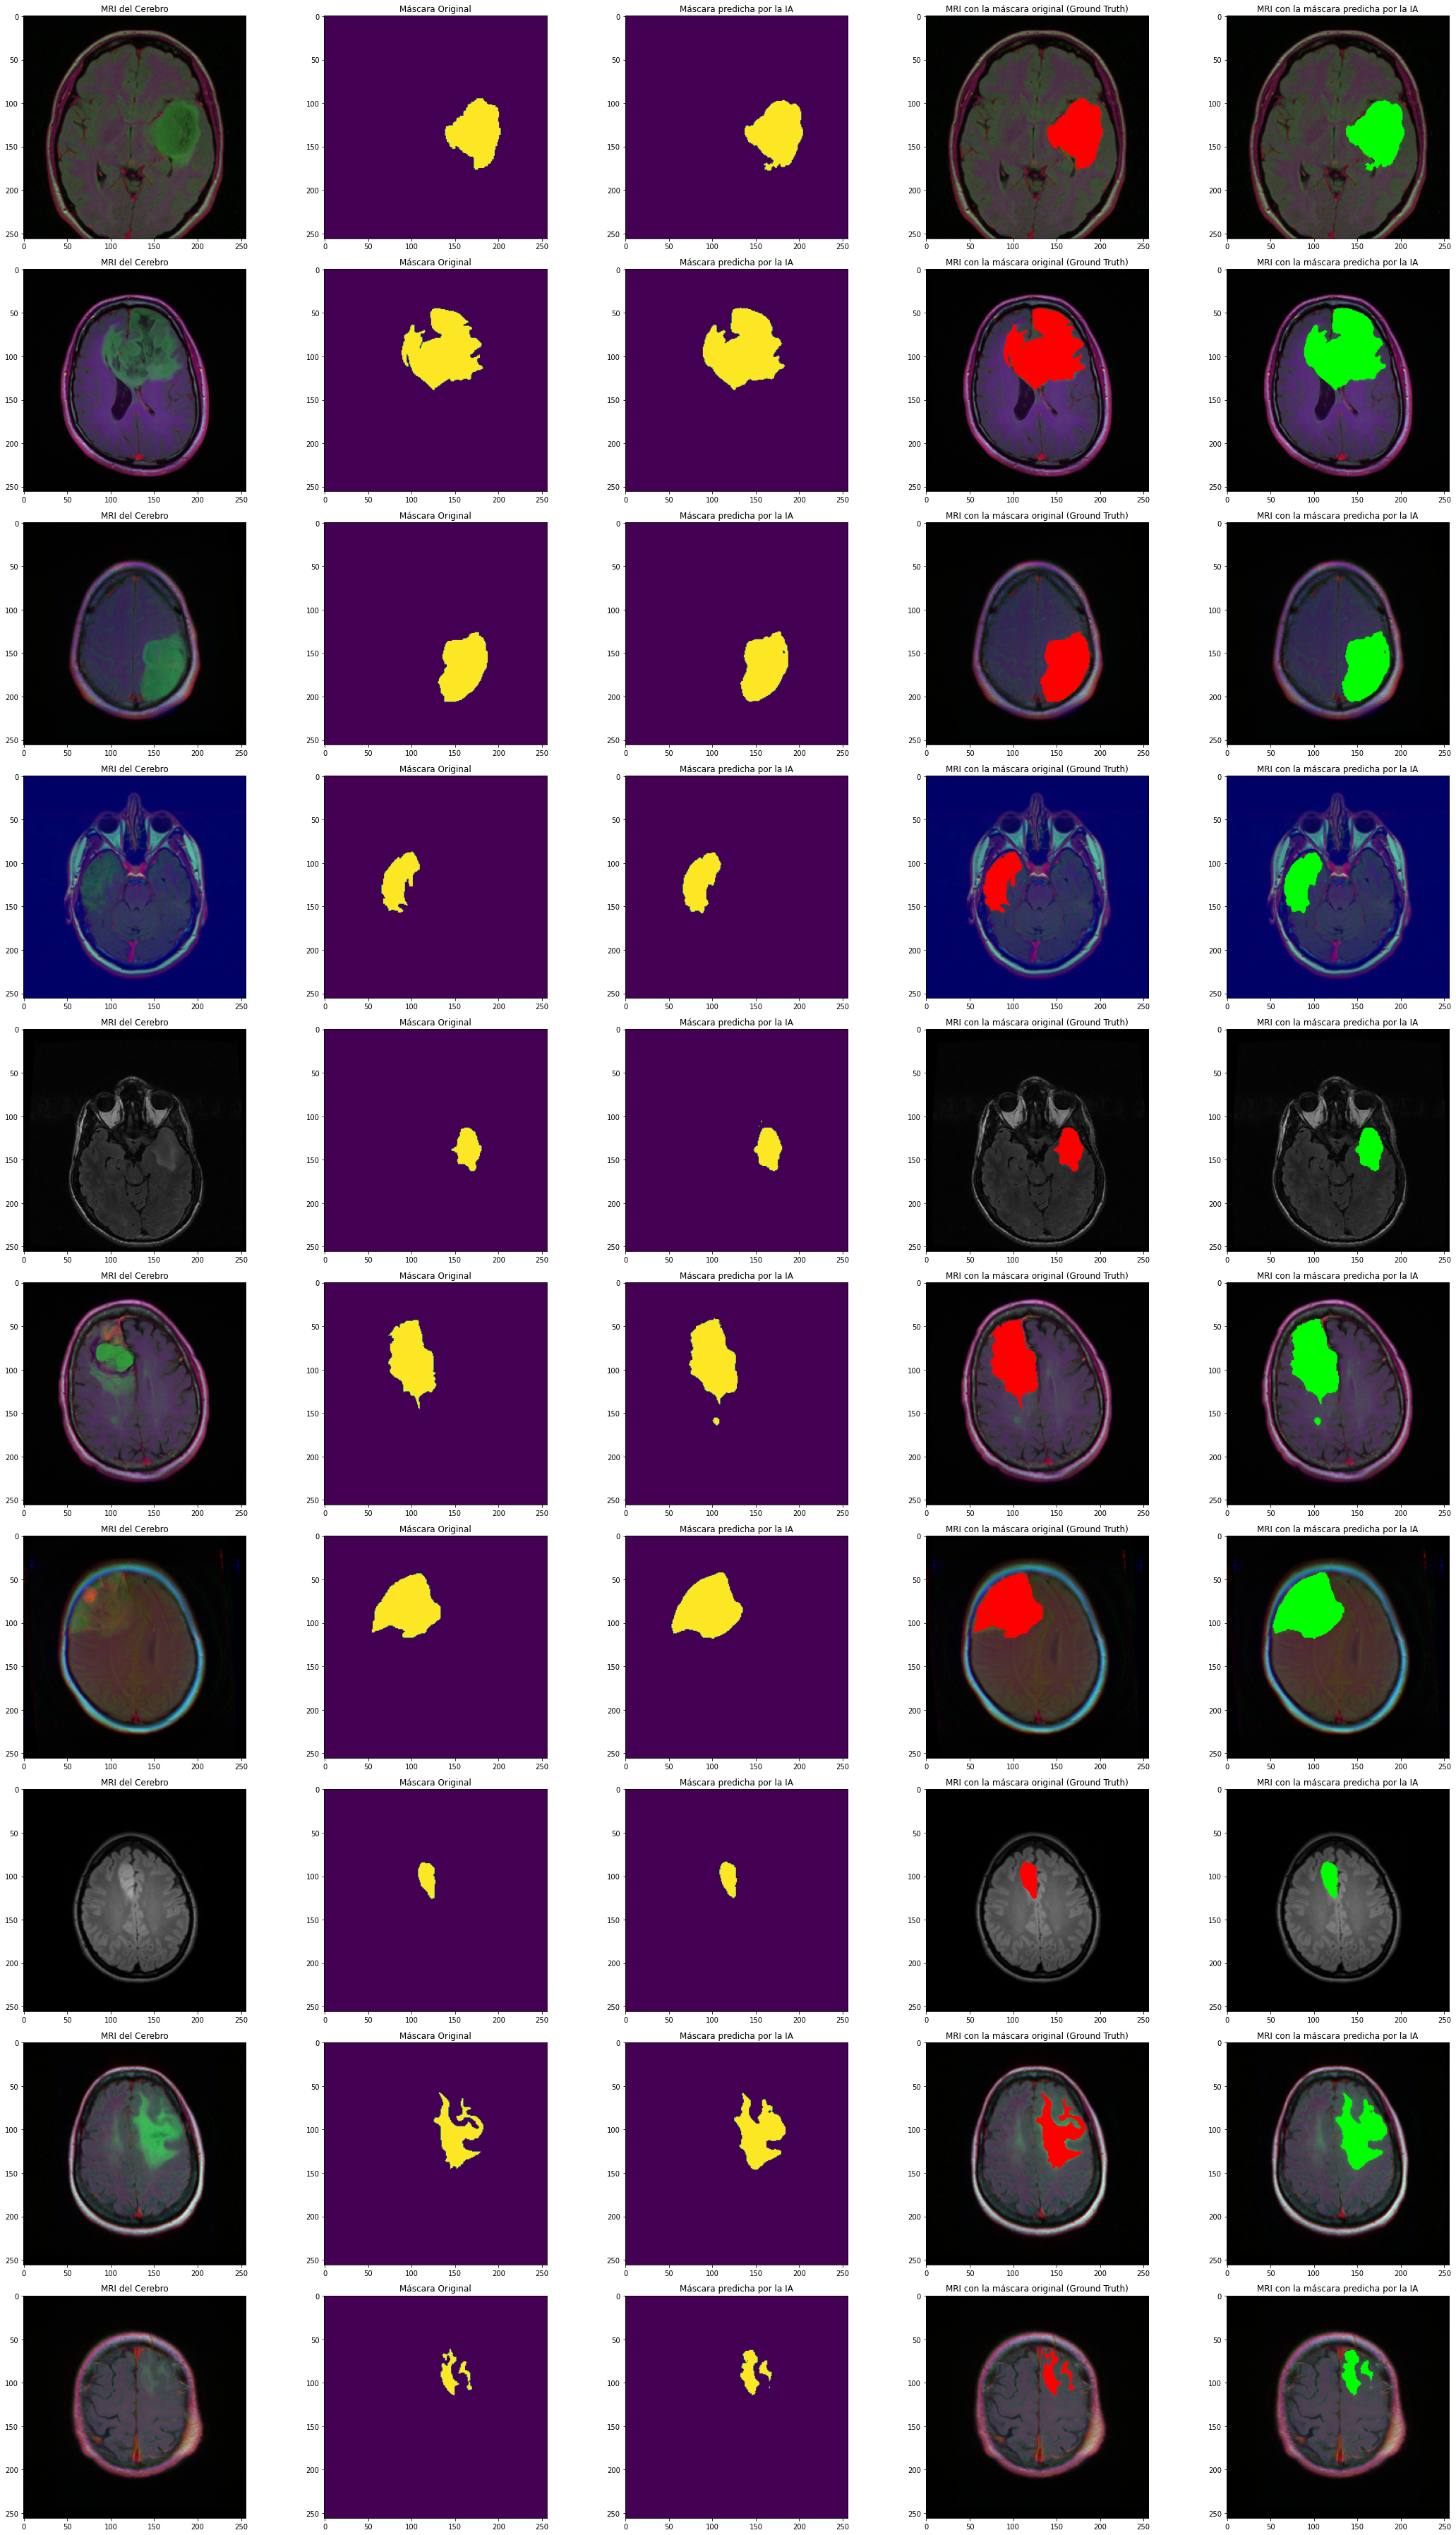

In [ ]:
count = 0 
fig, axs = plt.subplots(10, 5, figsize=(30, 50))
for i in range(len(df_pred)):
  if df_pred['has_mask'][i] == 1 and count < 10:
    # leer las imágenes y convertirlas a formato RGB
    img = io.imread(df_pred.image_path[i])
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    axs[count][0].title.set_text("MRI del Cerebro")
    axs[count][0].imshow(img)

    # Obtenemos la máscara para la imagen
    mask = io.imread(df_pred.mask_path[i])
    axs[count][1].title.set_text("Máscara Original")
    axs[count][1].imshow(mask)

    # Obtenemos la máscara de predicción para dicha imagen
    predicted_mask = np.asarray(df_pred.predicted_mask[i])[0].squeeze().round()
    axs[count][2].title.set_text("Máscara predicha por la IA")
    axs[count][2].imshow(predicted_mask)
    
    # Aplicamos la máscara a la imagen 'mask==255'
    img[mask == 255] = (255, 0, 0)
    axs[count][3].title.set_text("MRI con la máscara original (Ground Truth)")
    axs[count][3].imshow(img)

    img_ = io.imread(df_pred.image_path[i])
    img_ = cv2.cvtColor(img_, cv2.COLOR_BGR2RGB)
    img_[predicted_mask == 1] = (0, 255, 0)
    axs[count][4].title.set_text("MRI con la máscara predicha por la IA")
    axs[count][4].imshow(img_)
    count += 1

fig.tight_layout()